<a href="https://colab.research.google.com/github/guiraposo/ML4Gravity/blob/main/ML4Waveforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waveform generation and detetection

Notebook based on the [MachineLearningForStrongGravity](https://github.com/raimonluna/) course given by Raimon Luna.

<br>

### In this notebook, we will see:

1. How to reduce the dimensionality of data by finding an appropriate basis of vectors.
2. How autoencoders "compress" the data by automatically identifying the governing parameters.
3. How we can use GANs to generate samples from the same distribution as the training data.<br>Original paper:<br>

 - Felipe F. Freitas, Carlos A. R. Herdeiro, António P. Morais, António Onofre, Roman Pasechnik, Eugen Radu, Nicolas Sanchis-Gual, Rui Santos, <i>Generating gravitational waveform libraries of exotic compact binaries with deep learning</i>, 2022. https://arxiv.org/abs/2203.01267

<br>

In [3]:
# Import relevant libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

In [4]:
def showcase(dataset1, dataset2 = None, Nrow = 2, Ncol = 3):
    fig, ax = plt.subplots(Nrow, Ncol,figsize = (8, 4))
    font = {'size'   : 10}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, 64, dtype = np.float32)

    if dataset2 is not None:
        entry = 0
        for i in range(Nrow):
            for j in range(Ncol):
                ax[i,j].plot(x, dataset1[entry, :], 'b', label = 'Data')
                ax[i,j].plot(x, dataset2[entry, :], 'r--', label = 'Approx')
                ax[i,j].legend(loc = 'upper left')
                entry += 1
    else:
        entry = 0
        for i in range(Nrow):
            for j in range(Ncol):
                ax[i,j].plot(x, dataset1[entry, :], 'b')
                entry += 1

# Synthetic Waveforms:

Let us start by generating a dataset with some toy waveforms. We choose a generator of the following type:

$$\psi = \sin(2 \pi k x)\, e^{-8x^2}, $$

representing a sinusoidal function with wave number $k$, modulated by a gaussian profile. For simplicity we shall consider only one parameter ($k$), but in other sections we shall try to extend this to additional parameters.

## Generating Waveforms

In [5]:
# Generating the dataset of synthetic waveforms
x       = np.linspace(-1, 1, 64, dtype = np.float32)
randoms = 5*np.random.rand(100)
data    = np.array([np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 ) for k in randoms])

## Train-test Splitting

In [6]:
# Standard splitting using sklearn
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

## Visualization of some examples:

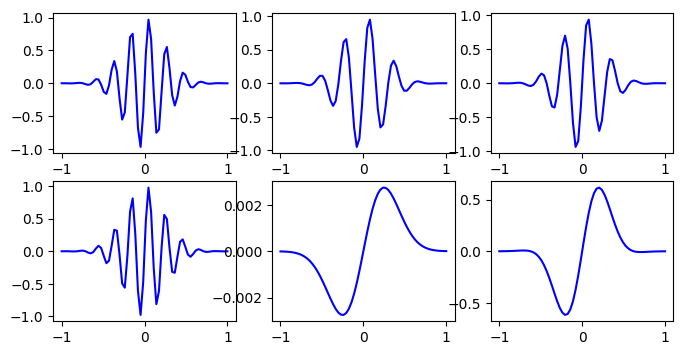

In [ ]:
showcase(data)

# PCA decomposition

We can start by using principal component analysis to reduce the dimensionality of our problem.

Our goal is to be able to be able to reduce the number of features, but still reproducing the waveform as well as possible.

## Training

In [7]:
pca = PCA(n_components = 10)
pca.fit(data_train);

## Testing and visualization

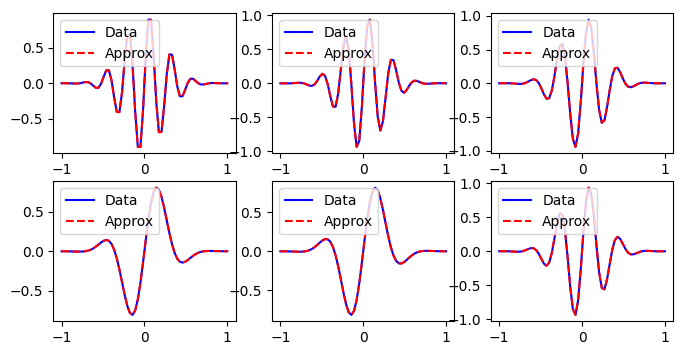

In [8]:
encoded = pca.transform(data_test)
decoded = pca.inverse_transform(encoded)
showcase(data_test, decoded)

As we can see it is clear that 10 principal components model very well the testing set. But how many components do we need?


## Minimum number of components
To see this more quantitatively we can perform do a more systematic check and look at the cumulative variance of the model.

Let us assume we want to preserve 99% of cumulative variance.

In [9]:
pca = PCA()
pca.fit(data_train);
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

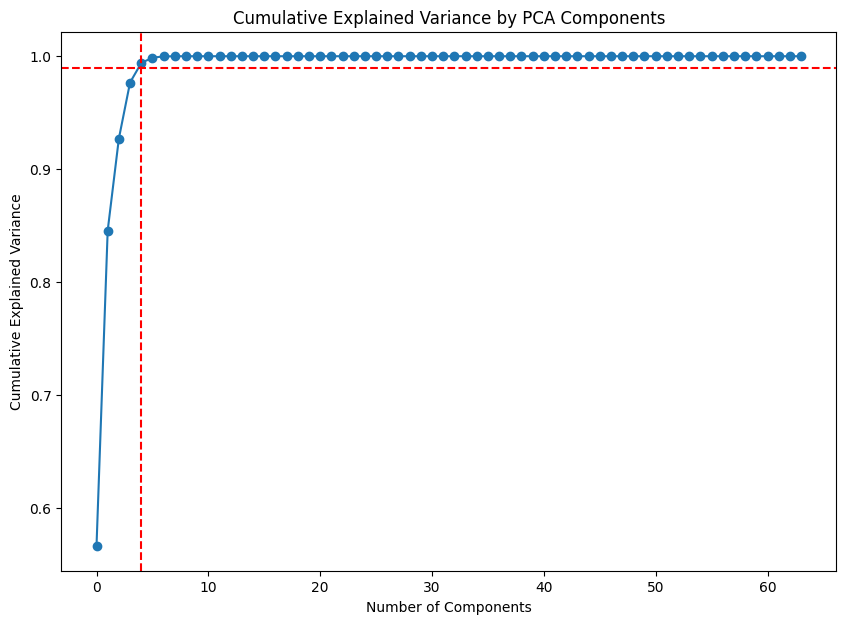

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()

The minimum number of components that we need to include to preserver a minimum of 99% of cumulative variance is 5, but we also see that around $n=6$, it saturates.

## Training with minimum number of components:

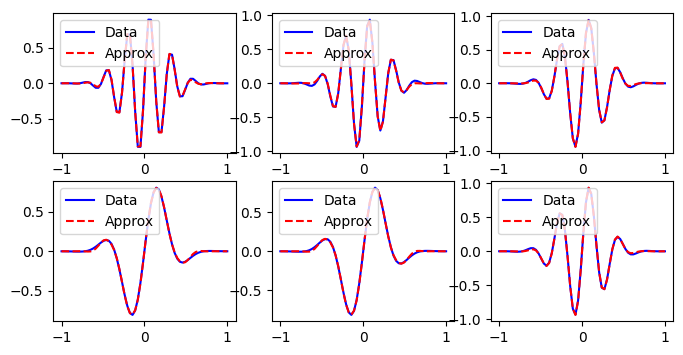

In [12]:
pca = PCA(n_components = 6)
pca.fit(data_train);
encoded = pca.transform(data_test)
decoded = pca.inverse_transform(encoded)
showcase(data_test, decoded)

# Singular Value Decomposition (SVD)

Here the idea is the same as before, however we are exploring a different method to achieve the dimensionality reduction.

In [19]:
svd = TruncatedSVD(n_components = 6)
svd.fit(data_train);

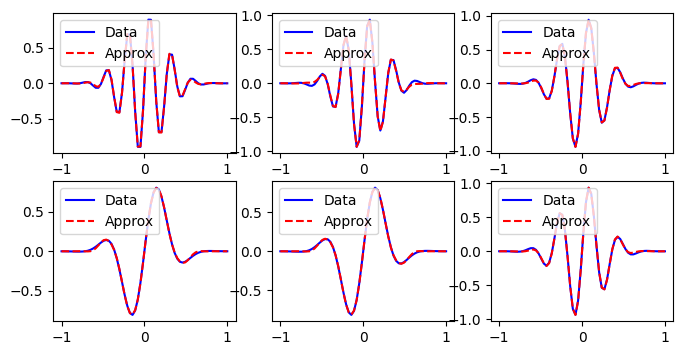

In [18]:
encoded = svd.transform(data_test)
decoded = svd.inverse_transform(encoded)
showcase(data_test, decoded)

In [23]:
svd = TruncatedSVD(n_components=20)
svd.fit(data_train);

explained_variance_ratio = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
print(n_components)

5


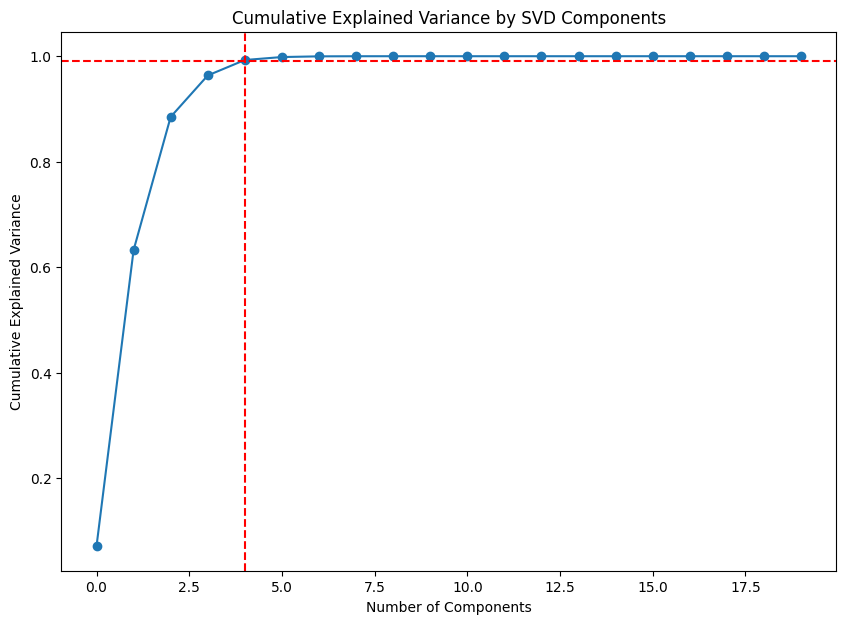

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by SVD Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()